# Download data

## Training data

In [16]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

--2021-05-15 12:23:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.160.144, 142.250.71.16, 142.250.195.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.160.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  3.17MB/s    in 87s     

2021-05-15 12:24:41 (1.64 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



## Validation data

In [185]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2021-05-15 20:46:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.195.176, 142.250.195.240, 142.250.71.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.195.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  2.66MB/s    in 4.8s    

2021-05-15 20:47:00 (2.30 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



# Data manipulation

Move data around and keep it in relevant directory

In [187]:
import os
import shutil
import zipfile

if not os.path.exists('./Data'):
    os.mkdir('Data')
# Train data
if not os.path.exists('./Data/horse-or-human/'):
    shutil.move('/tmp/horse-or-human.zip', './Data/')
    local_zip = './Data/horse-or-human.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./Data/horse-or-human')
    zip_ref.close()
    os.remove('./Data/horse-or-human.zip')
# Validation data
if not os.path.exists('./Data/validation-horse-or-human/'):
    shutil.move('/tmp/validation-horse-or-human.zip', './Data/')
    local_zip = './Data/validation-horse-or-human.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./Data/validation-horse-or-human')
    zip_ref.close()
    os.remove('./Data/validation-horse-or-human.zip')

# Play around with data

Load the data into variables and play witn the data to inspect it

In [22]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('./Data/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./Data/horse-or-human/humans')

# Getting image file names from horse and human directories respectively 
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

# Directory with our training horse pictures
val_horse_dir = os.path.join('./Data/validation-horse-or-human/horses')

# Directory with our training human pictures
val_human_dir = os.path.join('./Data/validation-horse-or-human/humans')

# Getting image file names from horse and human directories respectively 
val_horse_names = os.listdir(train_horse_dir)
val_human_names = os.listdir(train_human_dir)

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

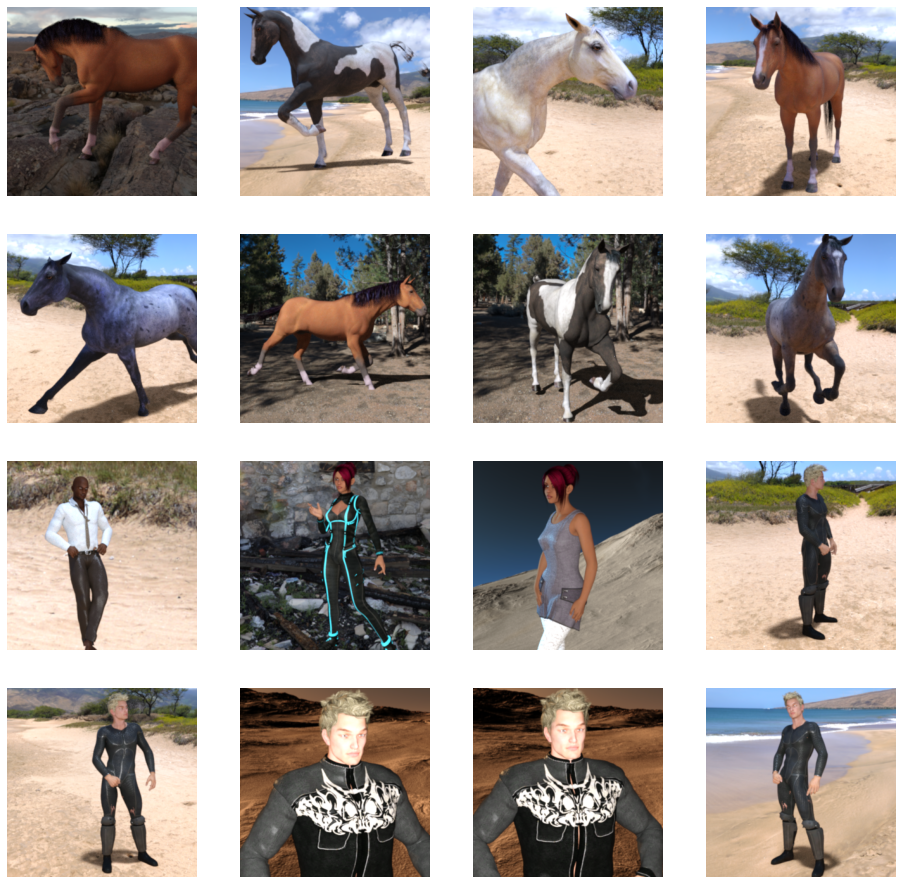

In [24]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Data generator

Creating train and test data generator

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_gen = train_datagen.flow_from_directory(
    "Data/horse-or-human/", 
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary'
)


Found 1027 images belonging to 2 classes.


# Defining model

We will define a not so shallow and not so deep neural network using convolutions with tf.keras

In [124]:
import tensorflow as tf 
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"), # If we don't add multiple layers of conv2D here then basically we are adding a lot of load on dense layer and we will end up with higher parameters than required
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.001),
    metrics=["accuracy"]
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 33, 33, 64)       

# Callback defination

In [180]:
class customCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs.get("accuracy") > 0.99:
            print("Stopping training because accuracy is more than 85%")
            self.model.stop_training = True

callback = customCallBack()

# Training

Training the model using a convolutional network

In [181]:
model.fit(
    train_gen,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    callbacks=[callback]    
)

Epoch 1/15
8/8 [==============================] - 29s 4s/step - loss: 6.1376e-05 - accuracy: 1.0000
Stopping training because accuracy is more than 85%


# Running the model

use data from disk and test it on the model trained

In [182]:
import numpy as np

def get_image_for_predicting(path):

    # This image is of type "PIL.JpegImagePlugin.JpegImageFile"
    image = tf.keras.preprocessing.image.load_img(path, target_size=(300, 300))

    # Converting it to numpy array
    x = tf.keras.preprocessing.image.img_to_array(image)
    x = x/255.0
    # Image had 4 channels and the last value was always 1 (assuming it is alpha channel) but i was not able to remove it at all. So using this method to remove the extra channel
    x = x[:,:,:3]
    # Will add a new dimension at the axis position mentioned
    x = np.expand_dims(x, axis=0)

    image = np.vstack([x])
    
    return image

images = get_image_for_predicting("Data/test_data/hqdefault.jpg")
classes = model.predict(images)

print("Class to index mapping : ", train_gen.class_indices)
print(classes[0])
if classes[0]>0.5:
    print("It is a human")
else:
    print("It is a horse")

Class to index mapping :  {'horses': 0, 'humans': 1}
[0.]
It is a horse


# Visualizations

Visualizing the intermediate layes to see what features were prominent when trying to distinguish between horse and humans

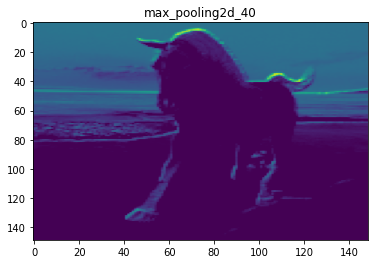

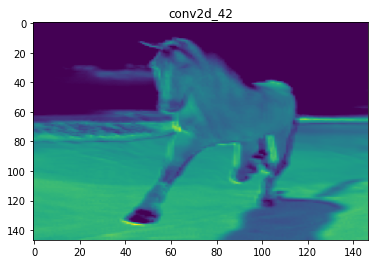

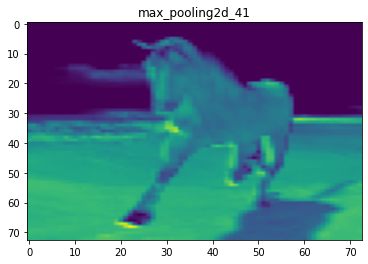

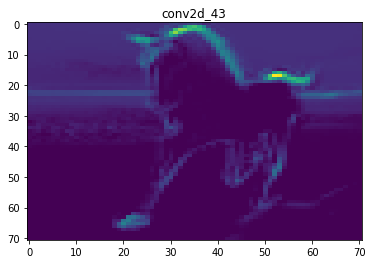

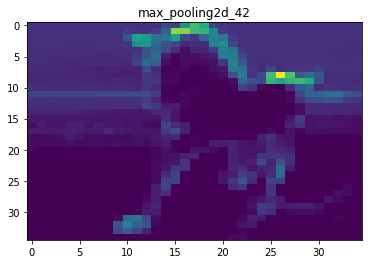

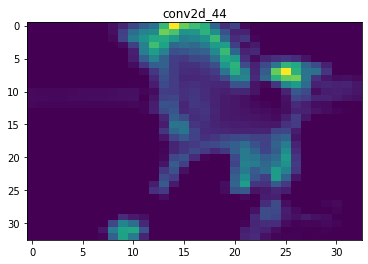

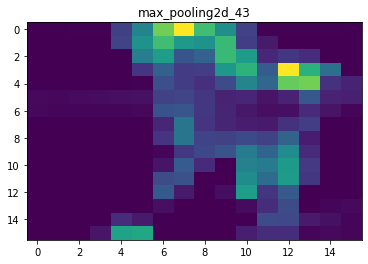

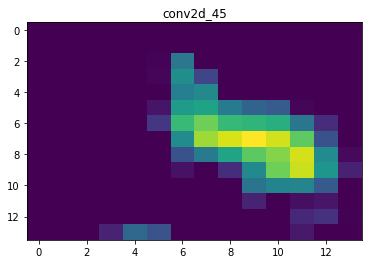

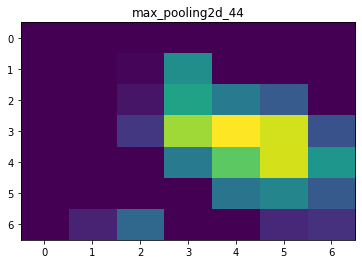

In [183]:

intermediate_layes = [layer.output for layer in model.layers[1:]]
intermediate_layes_names = [layer.name for layer in model.layers[1:]]
viz_model = tf.keras.models.Model(inputs=model.input, outputs=intermediate_layes)


image = get_image_for_predicting("Data/test_data/horse03-5.png")

feature_maps = viz_model.predict(image)
for layer_name, feature_map in zip(intermediate_layes_names, feature_maps):
    feature_map_shape = feature_map.shape
    if len(feature_map_shape) != 4:
        continue
    display_grid = np.zeros((feature_map_shape[1], feature_map_shape[2]))
    for i in range(feature_map_shape[-1]):
        display_grid[:,:] = feature_map[0,:,:,i]
        break
    scale = 20./feature_map_shape[-1]
    plt.figure()
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')